# Computer Assignment 6 (Neural Networks)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from abc import ABC, abstractmethod
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable
from collections import namedtuple

In [ ]:
DATA_DIR = 'data/'

TRAIN_IMAGES = DATA_DIR + 'TrainImgs.csv'
TRAIN_LABELS = DATA_DIR + 'TrainLabels.csv'
TEST_IMAGES  = DATA_DIR + 'TestImgs.csv'
TEST_LABELS  = DATA_DIR + 'TestLabels.csv'

CLASS_COUNT = 28
REMOVABLE_CLASSES = list(range(16, 28))

In [ ]:
Image = namedtuple('Image', ['pixels', 'label'])

## Part 1: Data Analysis and Preprocessing

In [ ]:
class DataLoader:

    def __init__(self, data: pd.DataFrame, labels: pd.DataFrame, n_classes: int, batch_size: Union[int, None] = None, shuffle: bool = False):
        assert len(data) == len(labels), 'Data and labels must have the same length'
        self._data: pd.DataFrame = data.copy()
        self._n_classes: int = n_classes
        self._batch_size: Union[int, None] = batch_size
        self._shuffle: bool = shuffle
        self._labels: pd.DataFrame = self._one_hot_encode(labels.copy(), n_classes)

    def _one_hot_encode(self, labels: pd.DataFrame, n_classes: int) -> pd.DataFrame:
        shape = (len(labels), n_classes)
        one_hot = np.zeros(shape)
        one_hot[np.arange(len(labels)), labels.values[:, 0] - 1] = 1
        return pd.DataFrame(one_hot)

    def _shuffle_data(self) -> None:
        data = pd.concat([self._data, self._labels], axis=1)
        data = data.sample(frac=1).reset_index(drop=True)
        self._data = data.iloc[:, :-self._n_classes]
        self._labels = data.iloc[:, -self._n_classes:]

    def __iter__(self) -> Iterable[tuple[np.ndarray, np.ndarray]]:
        if self._shuffle:
            self._shuffle_data()
            
        if self._batch_size == None:
            yield (self._data.values, self._labels.values)
            return
            
        for idx in range(0, len(self._data), self._batch_size):
            yield (self._data[idx:idx+self._batch_size].values,
                   self._labels[idx:idx+self._batch_size].values)
            
    def drop_classes(self, classes: list[int]) -> None:
        assert all([c in range(self._n_classes) for c in classes]), 'Classes must be in range [0, n_classes)'
        self._labels = self._labels.drop(columns=classes)
        self._labels = self._labels.loc[(self._labels != 0).any(axis=1)]
        self._data = self._data.loc[self._labels.index]
        self._data = self._data.reset_index(drop=True)
        self._labels = self._labels.reset_index(drop=True)
        self._n_classes = self._labels.shape[1]

    def scale(self, scale: Callable[[pd.Series], pd.Series]) -> None:
        self._data = self._data.apply(scale, axis=1)

    def get_class_images(self, class_idx: int) -> pd.DataFrame:
        assert class_idx in range(self._n_classes), 'Class index must be in range [0, n_classes)'
        return self._data[self._labels[class_idx] == 1]
    
    def get_labels(self) -> pd.DataFrame:
        return pd.DataFrame(np.argmax(self._labels.values, axis=1) + 1)

In [ ]:
train_images = pd.read_csv(TRAIN_IMAGES, header=None)
train_labels = pd.read_csv(TRAIN_LABELS, header=None)
train_data = DataLoader(train_images, train_labels, CLASS_COUNT, shuffle=True)

test_images = pd.read_csv(TEST_IMAGES, header=None)
test_labels = pd.read_csv(TEST_LABELS, header=None)
test_data = DataLoader(test_images, test_labels, CLASS_COUNT, shuffle=True)

### 1.1 Plot a Sample of Each Class

In [ ]:
def plot_images(images: list[Image], n_cols: int = 5) -> None:
    n_rows = math.ceil(len(images) / n_cols)
    _, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i, img in enumerate(images):
        ax = axs[i // n_cols, i % n_cols] # type: ignore
        ax.imshow(img.pixels, cmap='gray')
        ax.set_title(img.label)
        ax.axis('off')
    plt.show()

There are 28 letters in the arabic alphabet. Each letter has a corresponding number from 1 to 28. The following code plots a random sample of each class.

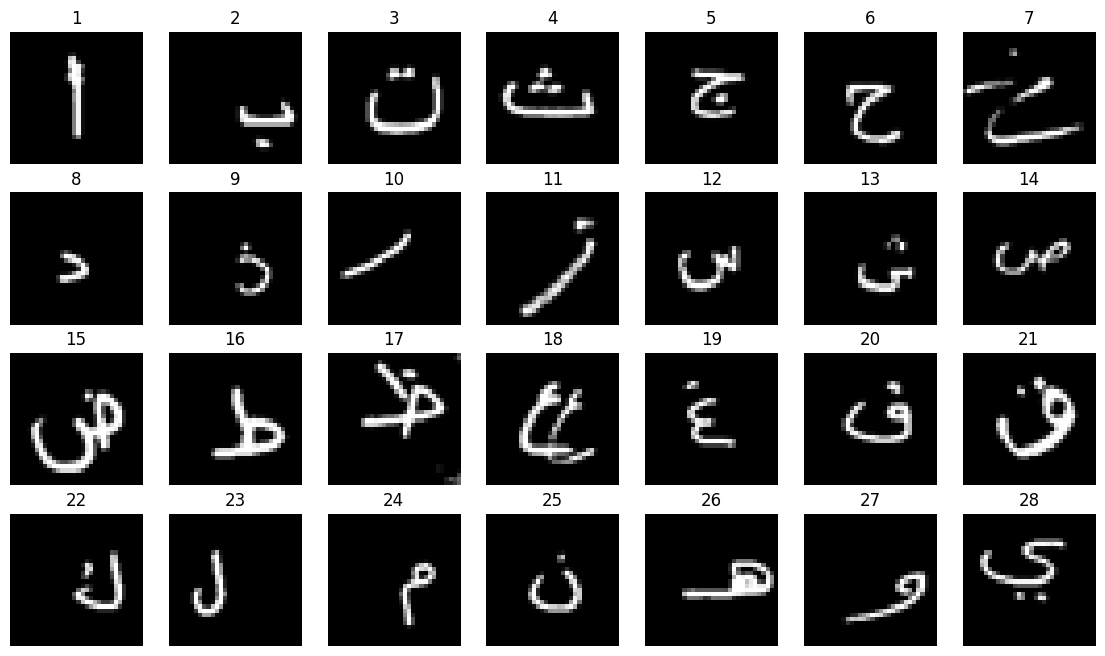

In [ ]:
imgs = []
for label in range(CLASS_COUNT):
    img = train_data.get_class_images(label).sample(n=1).values[0].reshape(32, 32)
    img = np.transpose(img)
    imgs.append(Image(img, label + 1))
plot_images(imgs, 7)

### 1.2 Pixels Range

All the pixels in the dataset are in the range [0, 255]. The following code finds the minimum and maximum values of the pixels.

In [ ]:
minimum = train_images.min().min()
maximum = train_images.max().max()
print(f'Minimum: {minimum}, Maximum: {maximum}')

Minimum: 0, Maximum: 255


### 1.3 Number of Classes and Samples

In [ ]:
class_count = train_labels[0].nunique()
samples_count = train_labels[0].count()
print(f'Number of classes: {class_count}, Number of samples: {samples_count}')

Number of classes: 28, Number of samples: 13440


### 1.4 Using the First 16 Classes

I will use the first 16 classes and the rest of them will be ignored.

In [ ]:
train_data.drop_classes(REMOVABLE_CLASSES)
test_data.drop_classes(REMOVABLE_CLASSES)

### 1.5 Number of Samples per Class

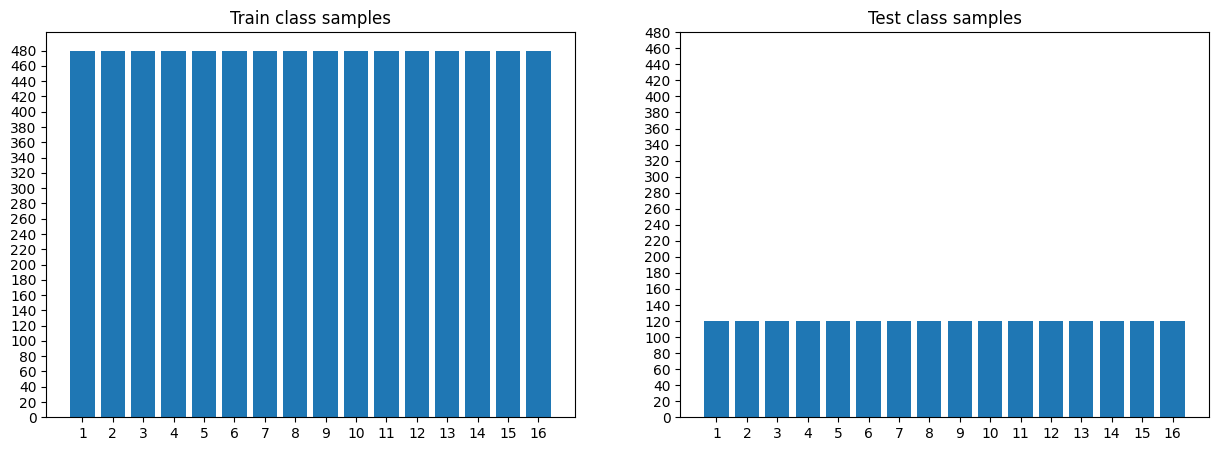

In [ ]:
train_lbl = train_data.get_labels()
test_lbl = test_data.get_labels()

train_class_samples = train_lbl[0].value_counts().sort_index()
test_class_samples = test_lbl[0].value_counts().sort_index()

_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(train_class_samples.index, train_class_samples.values) # type: ignore
axs[0].set_title('Train class samples')
axs[0].set_xticks(range(1, 17))
axs[0].set_yticks(range(0, 500, 20))
axs[1].bar(test_class_samples.index, test_class_samples.values) # type: ignore
axs[1].set_title('Test class samples')
axs[1].set_xticks(range(1, 17))
axs[1].set_yticks(range(0, 500, 20))
plt.show()

As it can be seen from the previous plots, the number of samples per class are equal and the dataset is balanced. The training set has 16 classes and each class has 480 samples. The test set has 16 classes and each class has 120 samples.

### 1.6 Scaling the Data

In [ ]:
train_data.scale(lambda x: (x - minimum) / (maximum - minimum)) # x /= 255
test_data.scale(lambda x: (x - minimum) / (maximum - minimum)) # x /= 255

The weights will be updated based on the difference between the predicted value and the actual value. If the values of the pixels are in the range [0, 255], the difference between the predicted value and the actual value will be in the range [0, 255]. This will cause the weights to be updated by a large amount, which will make the neural network **take a long time to converge**. To avoid this problem, we will scale (normalize) the data to be in the range [0, 1].

### 1.7 One-Hot Encoding

Labels are one-hot encoded inside the `DataLoader` class. If we don't use one-hot encoding, misclassification will be penalized more than it should be. For example, if the actual label is 1 and the predicted label is 2, the loss will be 1. If the actual label is 1 and the predicted label is 3, the loss will be 2. However, the difference between 1 and 2 is the same as the difference between 1 and 3. Therefore, we should use one-hot encoding to avoid this problem.  
As we are using one-hot encoding, the last layer of the neural network should have 16 neurons, one for each class. The index of the neuron with the highest value will be the predicted label.

## Part 2: Building the Neural Network

### Activation Functions

In [ ]:
class ActivationFunction(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def _val(self, matrix: np.ndarray) -> np.ndarray:
        pass

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self._val(matrix)
    
    @abstractmethod
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        pass

Now we define the following activation functions:

- Identical
- ReLU
- Leaky ReLU
- Sigmoid
- Softmax
- Tanh

#### Identical

This activation function is calculated as follows:

$$f(x) = x$$

The derivative of this activation function is calculated as follows:

$$f'(x) = 1$$

In [ ]:
class Identical(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        identical_value = np.copy(matrix).astype(np.float64)
        return identical_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        identical_derivative = np.ones(matrix.shape).astype(np.float64)
        return identical_derivative

#### ReLU

This activation function is calculated as follows:

$$f(x) = \max(0,\ x)$$

The derivative of this activation function is calculated as follows:

$$f'(x) = \begin{cases} 0 & x < 0 \\ 1 & x \geq 0 \end{cases}$$

In [ ]:
class ReLU(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        relu_value = np.copy(matrix).astype(np.float64)
        relu_value[relu_value < 0] = 0
        return relu_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        relu_derivative = np.copy(matrix).astype(np.float64)
        relu_derivative[relu_derivative < 0] = 0
        relu_derivative[relu_derivative > 0] = 1
        return relu_derivative

#### Leaky ReLU

This activation function is calculated as follows:

$$f(x) = \begin{cases} \alpha x & x < 0 \\ x & x \geq 0 \end{cases}$$

The derivative of this activation function is calculated as follows:

$$f'(x) = \begin{cases} \alpha & x < 0 \\ 1 & x \geq 0 \end{cases}$$

The special case of `LeakyReLU` with $\alpha = 0$ is `ReLU`.

In [ ]:
class LeakyReLU(ActivationFunction):

    def __init__(self, negative_slope: float = 0.01):
        super().__init__()
        self._negative_slope: float = negative_slope

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_value = np.copy(matrix).astype(np.float64)
        leaky_relu_value = np.where(leaky_relu_value > 0, leaky_relu_value, leaky_relu_value * self._negative_slope)
        return leaky_relu_value
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_derivative = np.copy(matrix).astype(np.float64)
        leaky_relu_derivative[leaky_relu_derivative > 0] = 1
        leaky_relu_derivative[leaky_relu_derivative < 0] = self._negative_slope
        return leaky_relu_derivative

#### Sigmoid

This activation function is calculated as follows:

$$f(x) = \frac{1}{1 + e^{-x}}$$

The derivative of this activation function is calculated as follows:

$$f'(x) = f(x) \cdot (1 - f(x)) = \frac{e^{-x}}{(1 + e^{-x})^2}$$

In [ ]:
class Sigmoid(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_value = np.copy(matrix).astype(np.float64)
        sigmoid_value = 1 / (1 + np.exp(-sigmoid_value))
        return sigmoid_value
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_derivative = self._val(matrix)
        sigmoid_derivative = sigmoid_derivative * (1 - sigmoid_derivative)
        return sigmoid_derivative

#### Softmax

This activation function is calculated as follows:

$$f(x) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

The derivative of this activation function is not implemented because it is not needed in this assignment.

In [ ]:
class Softmax(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        softmax_value = np.copy(matrix).astype(np.float64)
        softmax_value = np.exp(softmax_value)
        softmax_value = softmax_value / np.sum(softmax_value, axis=1, keepdims=True)
        return softmax_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        raise NotImplementedError('Softmax derivative is not implemented')

#### Tanh

This activation function is calculated as follows:

$$f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

The derivative of this activation function is calculated as follows:

$$f'(x) = 1 - f^2(x) = 1 - \frac{(e^x - e^{-x})^2}{(e^x + e^{-x})^2}$$

In [ ]:
class Tanh(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        tanh_value = np.copy(matrix).astype(np.float64)
        tanh_value = np.tanh(tanh_value)
        return tanh_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        tanh_derivative = self._val(matrix)
        tanh_derivative = (1 - tanh_derivative) * (1 + tanh_derivative)
        return tanh_derivative

### Loss Functions

In [ ]:
class LossFunction(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def _val(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        pass

    def __call__(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        assert predicted_val.shape == expected_val.shape, 'predicted_val and expected_val must have the same shape'
        return self._val(predicted_val, expected_val)
    
    @abstractmethod
    def derivative(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        pass

Now we define the following loss functions:

- Mean Squared Error
- Cross Entropy

#### Mean Squared Error

This loss function is calculated as follows:

$$L = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2$$

The derivative of this loss function is calculated as follows:

$$\frac{\partial L}{\partial \hat{y}_i} = \frac{2}{n} (\hat{y}_i - y_i)$$

Where $y_i$ is the expected value and $\hat{y}_i$ is the predicted value.

In [ ]:
class MeanSquaredError(LossFunction):

    def __init__(self):
        super().__init__()

    def _val(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        mse_value = predicted_val - expected_val
        mse_value = np.square(mse_value)
        mse_value = mse_value.sum(axis=1) / predicted_val.shape[1]
        return mse_value

    def derivative(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        assert predicted_val.shape == expected_val.shape, 'predicted_val and expected_val must have the same shape'
        mse_derivative = predicted_val - expected_val
        mse_derivative = mse_derivative * 2 / predicted_val.shape[1]
        return mse_derivative

#### Cross Entropy

Here I use `Softmax` as the activation function of the output layer. This loss function is calculated as follows:

$$L = -\sum\limits_{i=1}^n y_i \log(softmax(\hat{y}_i))$$

The derivative of this loss function is calculated as follows:

$$\frac{\partial L}{\partial \hat{y}_i} = softmax(\hat{y}_i) - y_i$$

Where $y_i$ is the expected value and $\hat{y}_i$ is the predicted value.

In [ ]:
class CrossEntropy(LossFunction):

    def __init__(self):
        super().__init__()
        self._softmax = Softmax()

    def _val(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        ce_value = np.copy(expected_val).astype(np.float64)
        ce_value = ce_value * np.log(self._softmax(predicted_val))
        ce_value = -ce_value.sum(axis=1, keepdims=True)
        return ce_value
    
    def derivative(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        ce_derivative = self._softmax(predicted_val) - expected_val
        return ce_derivative

### Layer

In [ ]:
class WeightDist(Enum):
    
    NORMAL = 1
    UNIFORM = 2


@dataclass
class WeightInitializer:

    dist: WeightDist
    mean: float = 0.0
    std: float = 1.0
    low: float = -1.0
    high: float = 1.0

    def __call__(self, shape: tuple[int, int]) -> np.ndarray:
        if self.dist == WeightDist.NORMAL:
            return np.random.normal(self.mean, self.std, shape)
        elif self.dist == WeightDist.UNIFORM:
            return np.random.uniform(self.low, self.high, shape)
        else:
            raise ValueError('Invalid weight distribution')

In [ ]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_STD = 0, 0.05, 0., 1.

    def __init__(self, input_size: int, output_size: int, activation: ActivationFunction = Identical(), 
                 init_weight_dist: WeightDist = WeightDist.UNIFORM, **init_params):
        self._n_neurons: int = output_size
        self._activation: ActivationFunction = activation
        self._weights: np.ndarray = self._init_weights(input_size, output_size, init_weight_dist, **init_params)
        self._bias: np.ndarray = self._init_weights(1, output_size, init_weight_dist, **init_params)

        self._last_input: Union[np.ndarray, None] = None
        self._last_activation_input: Union[np.ndarray, None] = None
        self._last_activation_output: Union[np.ndarray, None] = None
        self._last_activation_derivative: Union[np.ndarray, None] = None

    def _init_weights(self, input_size: int, output_size: int, init_weight_dist: WeightDist, **init_params) -> np.ndarray:
        low  = init_params.get('low', self.DEFAULT_LOW)
        high = init_params.get('high', self.DEFAULT_HIGH)
        mean = init_params.get('mean', self.DEFAULT_MEAN)
        std  = init_params.get('std', self.DEFAULT_STD)
        initializer = WeightInitializer(dist=init_weight_dist, low=low, high=high, mean=mean, std=std)
        return initializer((input_size, output_size))
    
    def forward(self, layer_input: np.ndarray) -> np.ndarray:
        assert np.ndim(layer_input) == 2, 'layer_input must be a matrix'
        assert np.size(self._weights, 0) == np.size(layer_input, 1), 'layer_input must have the same number of columns as the number of rows in the weight matrix'
        
        self._last_input = layer_input
        self._last_activation_input = layer_input @ self._weights + self._bias
        self._last_activation_output = self._activation(self._last_activation_input)
        self._last_activation_derivative = self._activation.derivative(self._last_activation_input)
        return self._last_activation_output
    
    def update_weights(self, back_prop_tensor: np.ndarray, learning_rate: float) -> np.ndarray:
        assert np.ndim(back_prop_tensor) == 2, 'back_prop_tensor must be a matrix'
        assert np.size(back_prop_tensor, 0) == np.size(self._last_activation_derivative, 0), 'back_prop_tensor must have the same number of rows as the number of rows in the activation derivative matrix' # type: ignore
        assert np.size(back_prop_tensor, 1) == self._n_neurons, 'back_prop_tensor must have the same number of columns as the number of neurons in the layer'

        back_prop_tensor = np.copy(back_prop_tensor).astype(np.float64)
        dy = back_prop_tensor * self._last_activation_derivative # type: ignore
        dw = self._last_input.T @ dy # type: ignore
        db = np.ones((1, np.size(dy, 0))) @ dy

        back_prop_tensor = dy @ self._weights.T
        self._weights -= learning_rate * dw
        self._bias -= learning_rate * db
        return back_prop_tensor
    
    @property
    def weights(self) -> np.ndarray:
        return self._weights
    
    @property
    def bias(self) -> np.ndarray:
        return self._bias
    
    @property
    def n_neurons(self) -> int:
        return self._n_neurons
    
    @property
    def activation(self) -> ActivationFunction:
        return self._activation

### Feed Forward Neural Network

In [ ]:
class FeedForwardNN:

    def __init__(self, input_size: int):
        self._input_size: int = input_size
        self._output_size: int = input_size

        self._layers: list[Layer] = []
        self._loss: LossFunction = CrossEntropy()
        self._learning_rate: float = 1e-3

    def add_layer(self, n_neurons: int, activation: ActivationFunction = Identical(), 
                  init_weight_dist: WeightDist = WeightDist.UNIFORM, **init_params):
        assert n_neurons > 0, 'n_neurons must be greater than 0'
        input_size = self._layers[-1].n_neurons if len(self._layers) > 0 else self._input_size
        self._layers.append(Layer(input_size, n_neurons, activation, init_weight_dist, **init_params))
        self.output_size = n_neurons

    def set_training_params(self, loss: LossFunction = CrossEntropy(), learning_rate: float = 1e-3):
        self._loss = loss
        self._learning_rate = learning_rate

    def forward(self, network_input: np.ndarray) -> np.ndarray:
        assert self._layers, 'Network must have at least one layer'
        network_input = np.copy(network_input).astype(np.float64)
        for layer in self._layers:
            network_input = layer.forward(network_input)
        return network_input
    
    def fit(self, epochs: int, train_data: DataLoader, test_data: Union[DataLoader, None] = None, print_results: bool = True):
        assert self._layers, 'Network must have at least one layer'
        
        log: dict[str, list[float]] = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

        for epoch in range(epochs):
            if print_results:
                print(f'Epoch {epoch + 1}')
            
            average_accuracy, average_loss = self._train(train_data)
            log['train_loss'].append(average_loss)
            log['train_accuracy'].append(average_accuracy)
            if print_results:
                print(f'\tTrain: Average Accuracy: {average_accuracy:7.4f}%\tAverage Loss: {average_loss:7.4f}')
            
            if test_data is not None:
                average_accuracy, average_loss = self._test(test_data)
                log['test_loss'].append(average_loss)
                log['test_accuracy'].append(average_accuracy)
                if print_results:
                    print(f'\tTest:  Average Accuracy: {average_accuracy:7.4f}%\tAverage Loss: {average_loss:7.4f}')

        return log
    
    def _train(self, train_data: DataLoader) -> tuple[float, float]:
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in train_data: # type: ignore
            batch_accuracy, batch_loss = self._train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return float(np.mean(batch_accuracies)), float(np.mean(batch_losses))
    
    def _test(self, test_data: DataLoader) -> tuple[float, float]:
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in test_data: # type: ignore
            batch_accuracy, batch_loss = self._test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return float(np.mean(batch_accuracies)), float(np.mean(batch_losses))
    
    def _train_on_batch(self, x_train: np.ndarray, y_train: np.ndarray) -> tuple[float, float]:
        network_output = self.forward(x_train)
        batch_accuracy = self._compute_accuracy(network_output, y_train)
        batch_average_loss = np.mean(self._loss(network_output, y_train))
        self._update_weights(network_output, y_train)
        return batch_accuracy, float(batch_average_loss)
    
    def _test_on_batch(self, x_test: np.ndarray, y_test: np.ndarray) -> tuple[float, float]:
        network_output = self.forward(x_test)
        batch_accuracy = self._compute_accuracy(network_output, y_test)
        batch_average_loss = np.mean(self._loss(network_output, y_test))
        return batch_accuracy, float(batch_average_loss)
    
    def _get_labels(self, network_output: np.ndarray) -> np.ndarray:
        return np.argmax(network_output, axis=1)
    
    def _compute_accuracy(self, network_output: np.ndarray, expected_output: np.ndarray) -> float:
        return np.mean(self._get_labels(network_output) == self._get_labels(expected_output)) * 100
    
    def _update_weights(self, network_output: np.ndarray, expected_output: np.ndarray) -> None:
        back_prop_tensor = self._loss.derivative(network_output, expected_output)
        for layer in reversed(self._layers):
            back_prop_tensor = layer.update_weights(back_prop_tensor, self._learning_rate)

## Part 3: Data Classification

### 3.1 Training the Neural Network

#### 3.1.1 Training the Neural Network with the following parameters:

- Number of epochs: 100
- Learning rate: 0.005
- batch_size: 32
- Activation function: `ReLU` except for the output layer which uses `Identical`
- Initial weights distribution: `Normal` or `Uniform`

In [ ]:
def get_train_and_test_data(batch_size: int) -> tuple[DataLoader, DataLoader]:
    train_data = DataLoader(train_images, train_labels, 28, batch_size=batch_size, shuffle=True)
    test_data = DataLoader(test_images, test_labels, 28, batch_size=batch_size, shuffle=True)
    train_data.drop_classes(REMOVABLE_CLASSES)
    test_data.drop_classes(REMOVABLE_CLASSES)
    train_data.scale(lambda x: x / 255)
    test_data.scale(lambda x: x / 255)
    return train_data, test_data

In [ ]:
def plot_results(log: dict[str, list[float]]) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(log['train_loss'], label='Train Loss')
    ax1.plot(log['test_loss'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(log['train_accuracy'], label='Train Accuracy')
    ax2.plot(log['test_accuracy'], label='Test Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [ ]:
INPUT_SIZE: int = 32 * 32
LEARNING_RATE: float = 0.005
EPOCHS: int = 100
TRAIN_LOADER, TEST_LOADER = get_train_and_test_data(32)

In [ ]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(10, activation=ReLU())
network.add_layer(10, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy:  9.5443%	Average Loss:  2.6461
	Test:  Average Accuracy: 13.8542%	Average Loss:  2.4977
Epoch 2
	Train: Average Accuracy: 13.3984%	Average Loss:  2.4379
	Test:  Average Accuracy: 12.0312%	Average Loss:  2.3871
Epoch 3
	Train: Average Accuracy: 15.0000%	Average Loss:  2.3451
	Test:  Average Accuracy: 16.1458%	Average Loss:  2.2834
Epoch 4
	Train: Average Accuracy: 23.1380%	Average Loss:  2.0655
	Test:  Average Accuracy: 26.6146%	Average Loss:  1.9420
Epoch 5
	Train: Average Accuracy: 29.3490%	Average Loss:  1.8752
	Test:  Average Accuracy: 30.1562%	Average Loss:  1.8038
Epoch 6
	Train: Average Accuracy: 33.9453%	Average Loss:  1.7092
	Test:  Average Accuracy: 34.0625%	Average Loss:  1.6507
Epoch 7
	Train: Average Accuracy: 36.0286%	Average Loss:  1.6008
	Test:  Average Accuracy: 36.7188%	Average Loss:  1.5676
Epoch 8
	Train: Average Accuracy: 40.1693%	Average Loss:  1.4887
	Test:  Average Accuracy: 41.4062%	Average Loss:  1.4853
Epoch 9
	Train: Average 

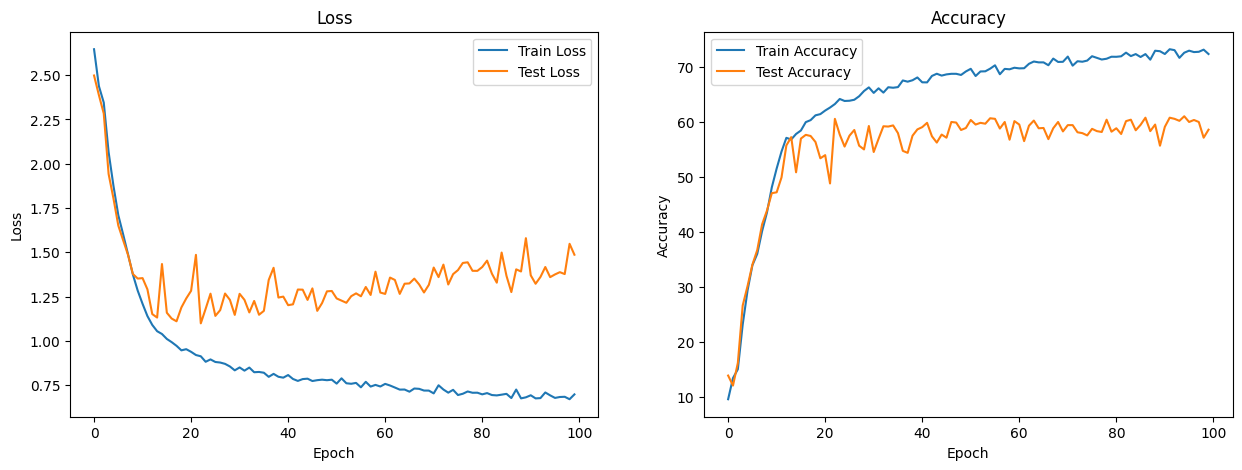

In [ ]:
plot_results(log)

#### 3.1.2 Increasing the Accuracy

Adding more layers and increasing the number of neurons in each layer will increase the accuracy. However, this will increase the training time.

In [ ]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy:  9.2969%	Average Loss:  2.6508
	Test:  Average Accuracy: 13.5938%	Average Loss:  2.5104
Epoch 2
	Train: Average Accuracy: 12.7083%	Average Loss:  2.4652
	Test:  Average Accuracy: 13.8542%	Average Loss:  2.3838
Epoch 3
	Train: Average Accuracy: 14.3750%	Average Loss:  2.3755
	Test:  Average Accuracy: 15.3125%	Average Loss:  2.3289
Epoch 4
	Train: Average Accuracy: 15.5469%	Average Loss:  2.3392
	Test:  Average Accuracy: 15.8333%	Average Loss:  2.2958
Epoch 5
	Train: Average Accuracy: 17.0312%	Average Loss:  2.2918
	Test:  Average Accuracy: 19.3750%	Average Loss:  2.1528
Epoch 6
	Train: Average Accuracy: 22.2266%	Average Loss:  2.0542
	Test:  Average Accuracy: 24.8958%	Average Loss:  1.9429
Epoch 7
	Train: Average Accuracy: 26.4453%	Average Loss:  1.9713
	Test:  Average Accuracy: 28.8542%	Average Loss:  1.8838
Epoch 8
	Train: Average Accuracy: 28.6458%	Average Loss:  1.9106
	Test:  Average Accuracy: 31.0417%	Average Loss:  1.8184
Epoch 9
	Train: Average 

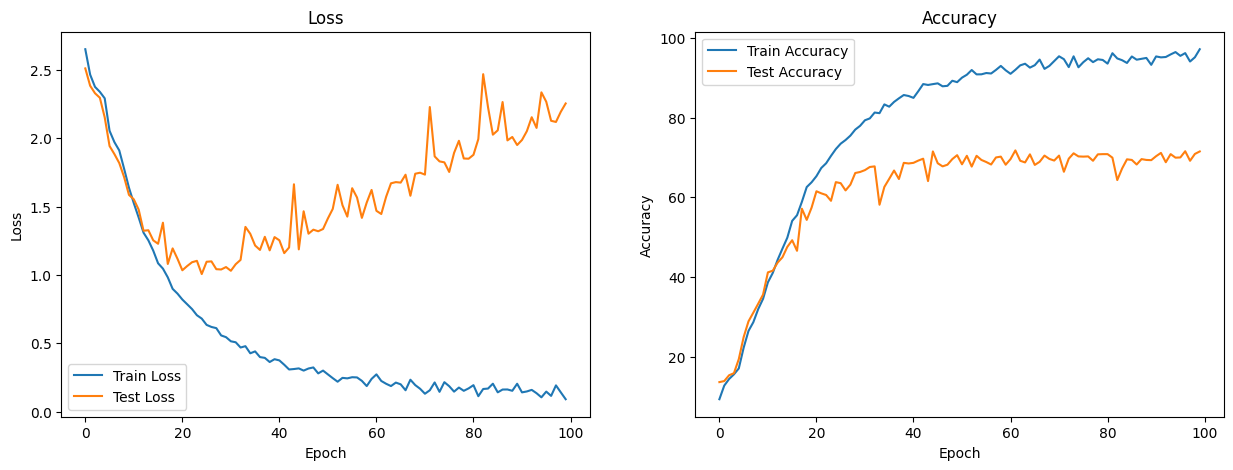

In [ ]:
plot_results(log)

As it is shown above, the training accuracy is 97% and the test accuracy is 71%.

In [ ]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(70, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy: 21.9271%	Average Loss:  2.3571
	Test:  Average Accuracy: 36.3542%	Average Loss:  1.8112
Epoch 2
	Train: Average Accuracy: 42.6953%	Average Loss:  1.6821
	Test:  Average Accuracy: 45.6771%	Average Loss:  1.5363
Epoch 3
	Train: Average Accuracy: 50.9896%	Average Loss:  1.4071
	Test:  Average Accuracy: 53.9062%	Average Loss:  1.3095
Epoch 4
	Train: Average Accuracy: 57.6302%	Average Loss:  1.2002
	Test:  Average Accuracy: 57.8125%	Average Loss:  1.1634
Epoch 5
	Train: Average Accuracy: 62.0703%	Average Loss:  1.0540
	Test:  Average Accuracy: 60.2083%	Average Loss:  1.1005
Epoch 6
	Train: Average Accuracy: 65.5859%	Average Loss:  0.9446
	Test:  Average Accuracy: 62.5000%	Average Loss:  1.0253
Epoch 7
	Train: Average Accuracy: 68.5677%	Average Loss:  0.8576
	Test:  Average Accuracy: 63.9583%	Average Loss:  0.9597
Epoch 8
	Train: Average Accuracy: 71.5365%	Average Loss:  0.7782
	Test:  Average Accuracy: 67.2396%	Average Loss:  0.8991
Epoch 9
	Train: Average 

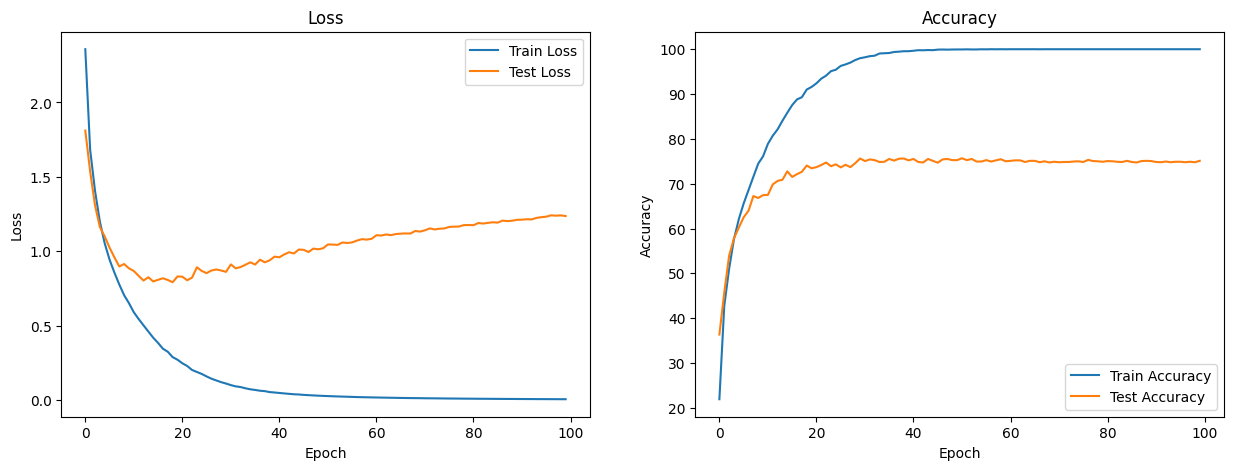

In [ ]:
plot_results(log)

In this case, the training accuracy has reached 100% and the test accuracy is about 75%.

### 3.2 Network Weighting

#### 3.2.1 Initialization of weights with 0

If we initialize all the weights with a constant value (e.g. $\alpha$), the neural network will be equivalent to a linear model and all the neurons will learn the same function. Consider that the last hidden layer in the neural network has 2 neurons and the output layer has a single neuron. If we use `Sigmoid` as the activation function of the output layer, the output of the neural network will be calculated as follows:

$$\hat{y} = \frac{1}{1 + e^{-(\alpha \cdot x_1 + \alpha \cdot x_2)}}$$

In this case, both neurons in the last hidden layer will have an identical influence on the output of the neural network, which will lead to identical gradients.  

Now consider that $\alpha = 0$. Two cases may occur:

- If the activation function is `Sigmoid` or anything else that $g(0) \neq 0$, we will have a linear model as mentioned above.
- If the activation function is `ReLU` or anything else that $g(0) = 0$, the output of the neural network will be 0. Therefore, the neural network will not learn anything.

### 3.3 The Effect of Learning Rate

#### 3.3.1 Learning Rate = 0.0005 ($\frac{1}{10}$ of the original learning rate)

In [ ]:
LEARNING_RATE: float = 0.0005

In [ ]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy:  6.0677%	Average Loss:  2.7389
	Test:  Average Accuracy:  6.8229%	Average Loss:  2.7244
Epoch 2
	Train: Average Accuracy:  6.8099%	Average Loss:  2.7195
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7114
Epoch 3
	Train: Average Accuracy:  6.4714%	Average Loss:  2.7034
	Test:  Average Accuracy:  7.3438%	Average Loss:  2.6904
Epoch 4
	Train: Average Accuracy:  8.2943%	Average Loss:  2.6838
	Test:  Average Accuracy:  7.8125%	Average Loss:  2.6705
Epoch 5
	Train: Average Accuracy:  8.5547%	Average Loss:  2.6633
	Test:  Average Accuracy:  9.9479%	Average Loss:  2.6484
Epoch 6
	Train: Average Accuracy: 10.3646%	Average Loss:  2.6399
	Test:  Average Accuracy: 10.9896%	Average Loss:  2.6213
Epoch 7
	Train: Average Accuracy: 11.8490%	Average Loss:  2.6118
	Test:  Average Accuracy: 12.1875%	Average Loss:  2.5909
Epoch 8
	Train: Average Accuracy: 12.1094%	Average Loss:  2.5804
	Test:  Average Accuracy: 12.5521%	Average Loss:  2.5578
Epoch 9
	Train: Average 

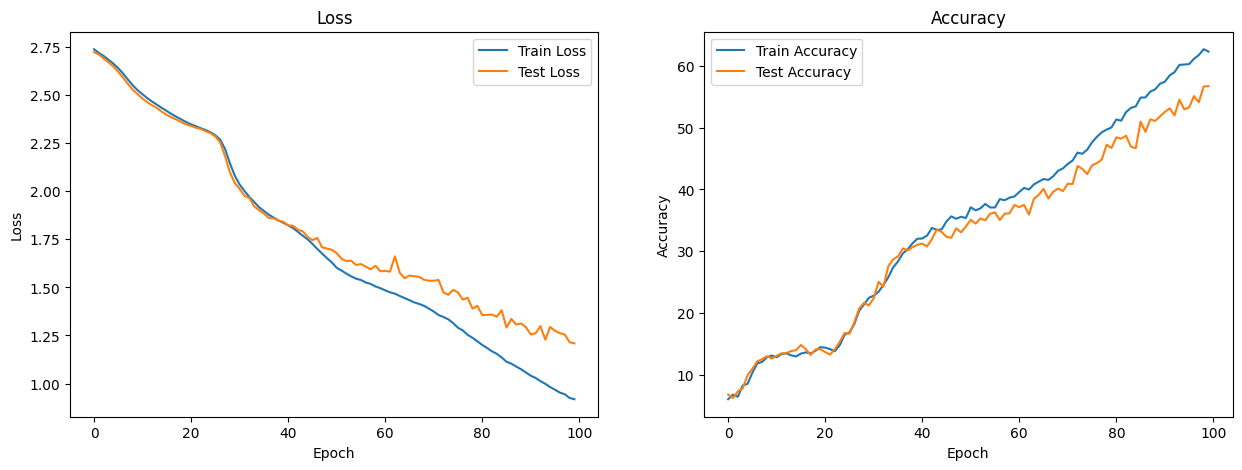

In [ ]:
plot_results(log)

As it is visible in the above figures, the model did not have enough time to learn the data because the learning rate was too small. Therefore, the model did not converge.

#### 3.3.2 Learning Rate = 0.05 ($10$ times the original learning rate)

In [ ]:
LEARNING_RATE: float = 0.05

In [ ]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy:  6.1849%	Average Loss:  2.8029
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7821
Epoch 2
	Train: Average Accuracy:  6.4844%	Average Loss:  2.7842
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7814
Epoch 3
	Train: Average Accuracy:  5.9505%	Average Loss:  2.7868
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7812
Epoch 4
	Train: Average Accuracy:  6.0026%	Average Loss:  2.7842
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7875
Epoch 5
	Train: Average Accuracy:  5.7031%	Average Loss:  2.7864
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7838
Epoch 6
	Train: Average Accuracy:  5.8854%	Average Loss:  2.7851
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7861
Epoch 7
	Train: Average Accuracy:  6.0938%	Average Loss:  2.7864
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7811
Epoch 8
	Train: Average Accuracy:  5.8464%	Average Loss:  2.7859
	Test:  Average Accuracy:  6.2500%	Average Loss:  2.7807
Epoch 9
	Train: Average 

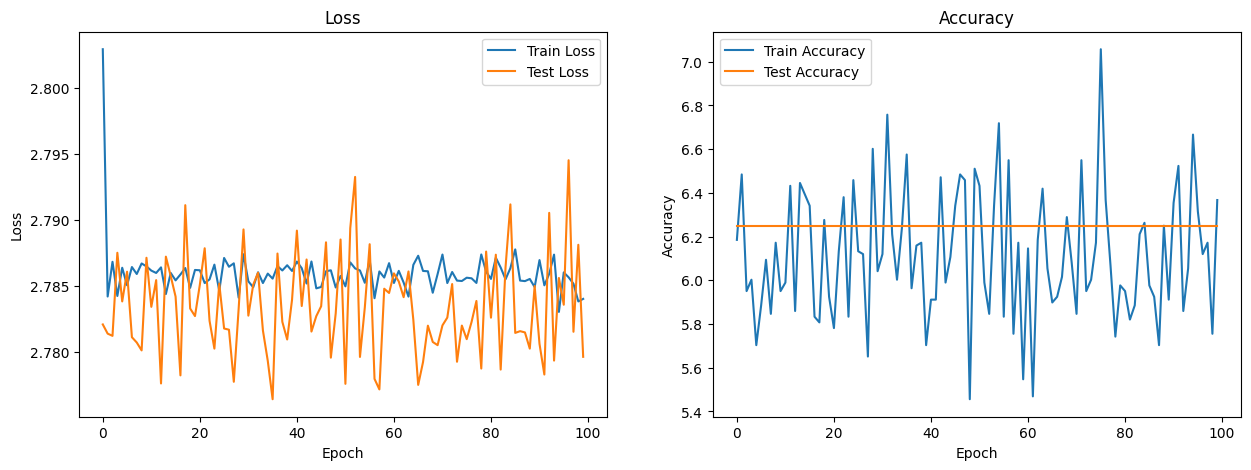

In [ ]:
plot_results(log)

As it is visible in the above figures, the model accuracy is stuck at about 6% because the learning rate was too large. Therefore, the model did not learn the data.

A good learning rate is the one that allows the model to converge without being too large or too small. Here we test the learning rates in the range $[0.0005, 0.05]$.

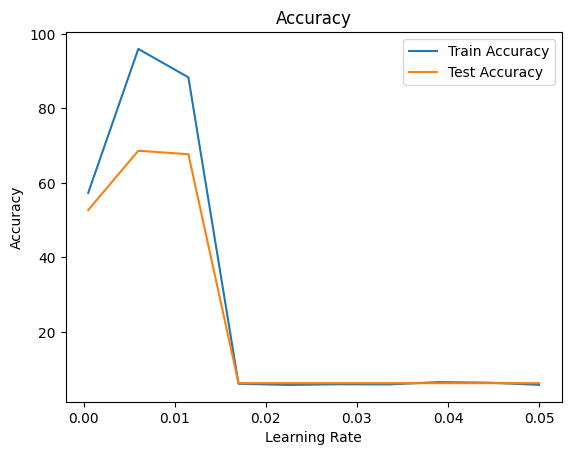

In [ ]:
learning_rates = np.linspace(0.0005, 0.05, 10)
accuracies = []
for learning_rate in learning_rates:
    network = FeedForwardNN(INPUT_SIZE)
    network.add_layer(35, activation=ReLU())
    network.add_layer(35, activation=ReLU())
    network.add_layer(35, activation=ReLU())
    network.add_layer(16, activation=Identical())
    network.set_training_params(learning_rate=learning_rate)
    log = network.fit(100, TRAIN_LOADER, TEST_LOADER, print_results=False)
    accuracies.append((log['train_accuracy'][-1], log['test_accuracy'][-1]))

plt.plot(learning_rates, [accuracy[0] for accuracy in accuracies], label='Train Accuracy')
plt.plot(learning_rates, [accuracy[1] for accuracy in accuracies], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(f'Best learning rate for train accuracy: {learning_rates[np.argmax([accuracy[0] for accuracy in accuracies])]}')
print(f'Best learning rate for test accuracy: {learning_rates[np.argmax([accuracy[1] for accuracy in accuracies])]}')

Best learning rate for train accuracy: 0.006
Best learning rate for test accuracy: 0.006


As it is shown above, the best learning rate would be $0.006$.

In [ ]:
LEARNING_RATE: float = 0.006

In [ ]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy: 10.4167%	Average Loss:  2.6265
	Test:  Average Accuracy: 12.9167%	Average Loss:  2.4818
Epoch 2
	Train: Average Accuracy: 12.3568%	Average Loss:  2.4494
	Test:  Average Accuracy: 12.9167%	Average Loss:  2.3748
Epoch 3
	Train: Average Accuracy: 14.2708%	Average Loss:  2.3730
	Test:  Average Accuracy: 14.1146%	Average Loss:  2.3717
Epoch 4
	Train: Average Accuracy: 15.5990%	Average Loss:  2.3372
	Test:  Average Accuracy: 16.8229%	Average Loss:  2.3507
Epoch 5
	Train: Average Accuracy: 18.5677%	Average Loss:  2.2037
	Test:  Average Accuracy: 24.4271%	Average Loss:  1.9894
Epoch 6
	Train: Average Accuracy: 23.9453%	Average Loss:  2.0141
	Test:  Average Accuracy: 26.8750%	Average Loss:  1.9365
Epoch 7
	Train: Average Accuracy: 28.7500%	Average Loss:  1.9011
	Test:  Average Accuracy: 29.8438%	Average Loss:  1.8016
Epoch 8
	Train: Average Accuracy: 32.0312%	Average Loss:  1.7372
	Test:  Average Accuracy: 35.5208%	Average Loss:  1.6382
Epoch 9
	Train: Average 

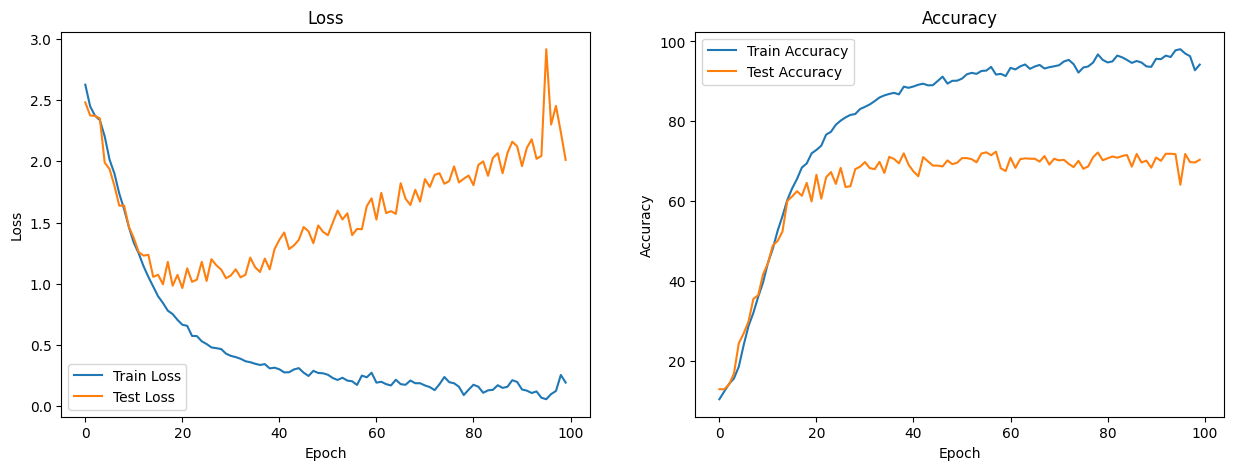

In [ ]:
plot_results(log)

### 3.4 The Effect of Activation Function

#### 3.4.1 `Sigmoid`, `Tanh`, `LeakyReLU`

Here we test the following activation functions:

- `Sigmoid`
- `Tanh`
- `LeakyReLU`

We compare the result of the mentioned activation functions with the one for `ReLU`.

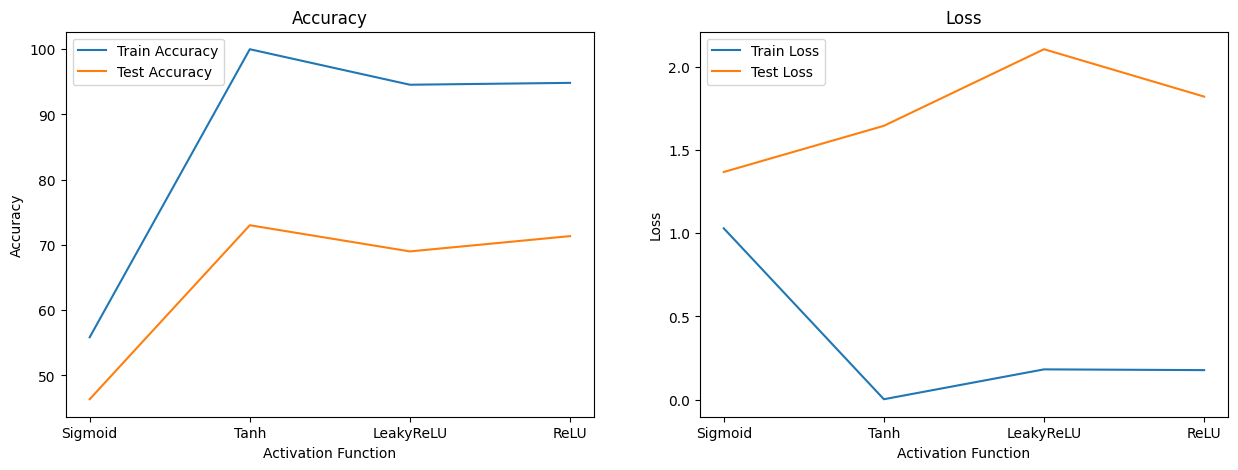

In [ ]:
activation_functions = [Sigmoid, Tanh, LeakyReLU, ReLU]
accuracies = []
losses = []
for activation_function in activation_functions:
    network = FeedForwardNN(INPUT_SIZE)
    network.add_layer(35, activation=activation_function())
    network.add_layer(35, activation=activation_function())
    network.add_layer(35, activation=activation_function())
    network.add_layer(16, activation=Identical())
    network.set_training_params(learning_rate=LEARNING_RATE)
    log = network.fit(100, TRAIN_LOADER, TEST_LOADER, print_results=False)
    accuracies.append((log['train_accuracy'][-1], log['test_accuracy'][-1]))
    losses.append((log['train_loss'][-1], log['test_loss'][-1]))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot([activation_function.__name__ for activation_function in activation_functions], [accuracy[0] for accuracy in accuracies], label='Train Accuracy')
ax1.plot([activation_function.__name__ for activation_function in activation_functions], [accuracy[1] for accuracy in accuracies], label='Test Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Activation Function')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot([activation_function.__name__ for activation_function in activation_functions], [loss[0] for loss in losses], label='Train Loss')
ax2.plot([activation_function.__name__ for activation_function in activation_functions], [loss[1] for loss in losses], label='Test Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Activation Function')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

`Sigmoid` has a very low accuracy and is not a good choice for this problem. On the other hand, `Tanh`, `LeakyReLU` and `ReLU` have similar accuracy.

#### 3.4.2 Why `Sigmoid` and `Tanh` are not good choices?

`Sigmoid` may not be a good choice because its gradient is in the range $[0, 0.25]$. It means that the gradient will vanish for large values of $x$ and the model will learn very slowly.  

`Tanh` also has a similar problem to `Sigmoid` except that its gradient is in the range $[0, 1]$.

#### 3.4.3 The Superiority of `LeakyReLU` over `ReLU`

`LeakyReLU` is fast and it converges well. Also, its gradient doesn't vanish for large values of $x$. `ReLU` has the same features as `LeakyReLU` except that it deletes the negative values of $x$ while `LeakyReLU` doesn't.

### 3.5 The Effect of Batch Size

#### 3.5.1 Batch Size = 16, 32, 256

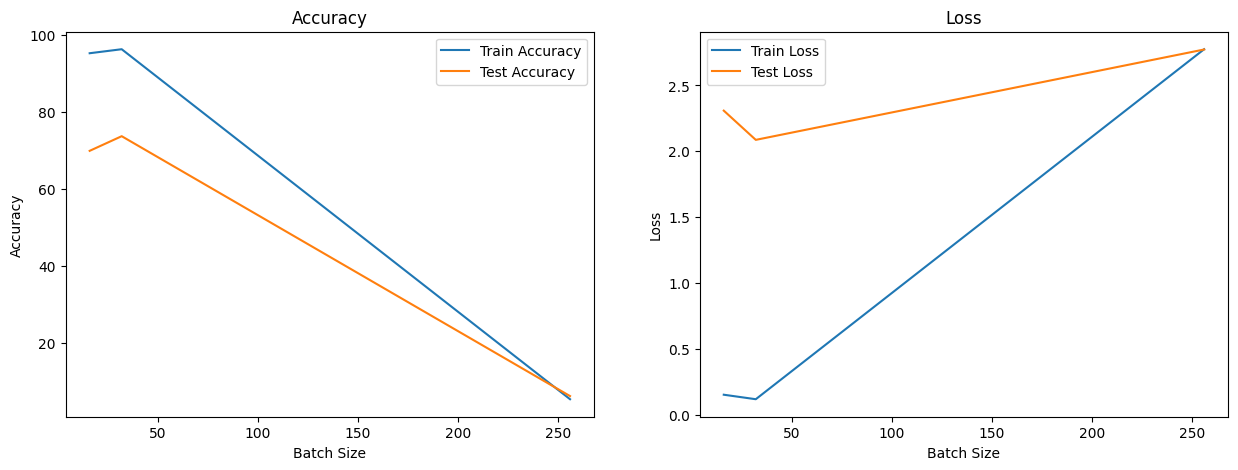

In [ ]:
batch_sizes = [16, 32, 256]
accuracies = []
losses = []
for batch_size in batch_sizes:
    TRAIN_LOADER, TEST_LOADER = get_train_and_test_data(batch_size)
    network = FeedForwardNN(INPUT_SIZE)
    network.add_layer(35, activation=LeakyReLU())
    network.add_layer(35, activation=LeakyReLU())
    network.add_layer(35, activation=LeakyReLU())
    network.add_layer(16, activation=Identical())
    network.set_training_params(learning_rate=LEARNING_RATE)
    log = network.fit(100, TRAIN_LOADER, TEST_LOADER, print_results=False)
    accuracies.append((log['train_accuracy'][-1], log['test_accuracy'][-1]))
    losses.append((log['train_loss'][-1], log['test_loss'][-1]))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(batch_sizes, [accuracy[0] for accuracy in accuracies], label='Train Accuracy')
ax1.plot(batch_sizes, [accuracy[1] for accuracy in accuracies], label='Test Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(batch_sizes, [loss[0] for loss in losses], label='Train Loss')
ax2.plot(batch_sizes, [loss[1] for loss in losses], label='Test Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

As it is visible in the above figures, the smaller the batch size is, the higher the accuracy is.

#### 3.5.2 Why do we use batch? What is the effect of small and large batch sizes?

The reason for using batch in training is to reduce the training time. For instance, if the batch size is 16, we will update the weights after each 16 samples. Therefore, the training time will be reduced by a factor of 16. However, if the batch size is too large, the model will not learn the data well because the weights will be updated after a large number of samples.  

As mentioned, when we use smaller batch sizes, the model will learn the data better. However, the training time will be longer. On the other hand, when we use larger batch sizes, the model will learn the data faster. However, the accuracy will be lower.

## Part 4: Using TensorFlow Library and Keras API

In [1]:
import warnings

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import classification_report

### 4.1 Data Preprcoessing and Designing the Network

First we should load the `CIFAR-10` dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Let's show some of the images in the dataset randomly.

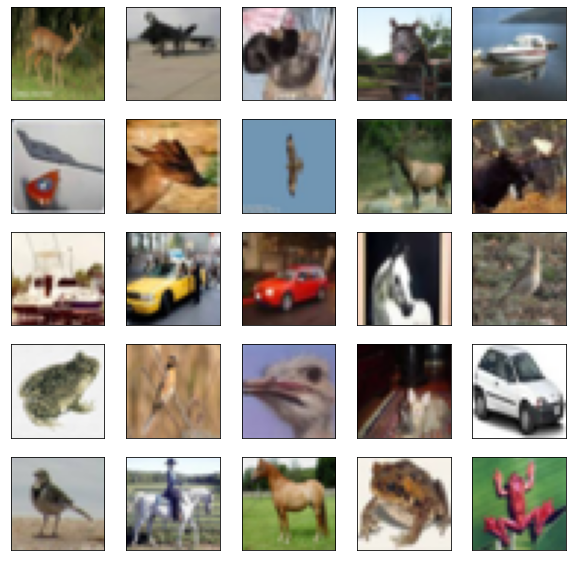

In [4]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im_rand = np.random.randint(0, x_train.shape[0])
    plt.imshow(x_train[im_rand], cmap=plt.cm.binary)
plt.show()

#### 4.1.1 Reshaping Images

In [3]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

#### 4.1.2 Normalization

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

#### 4.1.3 One-Hot Encoding

In [5]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### 4.1.4 Designing the Network

Here we design the network with the following parameters:

- Optimizer: `SGD`
- Learning Rate: 0.01
- Epochs: 10
- Batch Size: 32
- Activation Function: `ReLU` for all layers except the last one

In [7]:
def show_report(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1)))

In [8]:
def plot_results(history: keras.callbacks.History):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
model = keras.Sequential([
    keras.layers.Dense(35, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(35, activation='relu'),
    keras.layers.Dense(35, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                107555    
                                                                 
 dense_1 (Dense)             (None, 35)                1260      
                                                                 
 dense_2 (Dense)             (None, 35)                1260      
                                                                 
 dense_3 (Dense)             (None, 10)                360       
                                                                 
Total params: 110,435
Trainable params: 110,435
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 7s 3ms/step - loss: 1.9751 - accuracy: 0.2797 - val_loss: 1.9543 - val_accuracy: 0.2850
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7829 - accuracy: 0.3627 - val_loss: 1.7585 - val_accuracy: 0.3694
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7099 - accuracy: 0.3909 - val_loss: 1.7085 - val_accuracy: 0.3870
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6652 - accuracy: 0.4034 - val_loss: 1.7869 - val_accuracy: 0.3527
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6283 - accuracy: 0.4153 - val_loss: 1.6903 - val_accuracy: 0.4033
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5964 - accuracy: 0.4293 - val_loss: 1.5950 - val_accuracy: 0.4275
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5738 - accuracy: 0.4359 - val_loss: 1.6534 - val_accuracy:

In [12]:
show_report(model, x_train, y_train)
show_report(model, x_test, y_test)

1563/1563 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.39      0.59      0.47      5000
           1       0.44      0.73      0.55      5000
           2       0.31      0.34      0.32      5000
           3       0.42      0.17      0.24      5000
           4       0.33      0.46      0.39      5000
           5       0.53      0.20      0.29      5000
           6       0.52      0.41      0.46      5000
           7       0.53      0.47      0.49      5000
           8       0.53      0.68      0.60      5000
           9       0.55      0.35      0.43      5000

    accuracy                           0.44     50000
   macro avg       0.46      0.44      0.42     50000
weighted avg       0.46      0.44      0.42     50000

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.40      0.61      0.48      1000
           1       0

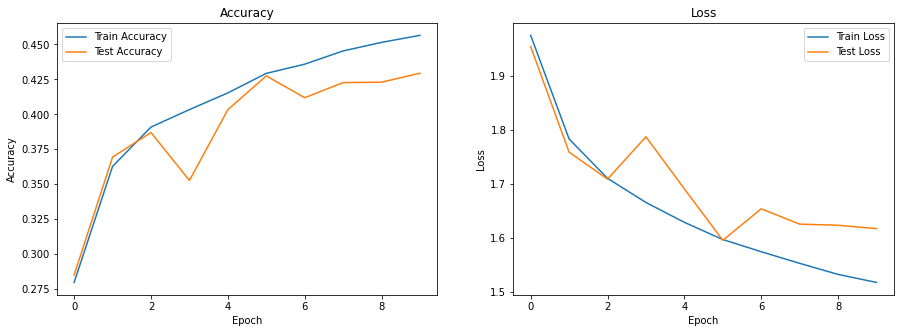

In [13]:
plot_results(history)

In [7]:
model = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              3146752   
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_10 (Dense)            (None, 10)               

In [29]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8077 - accuracy: 0.3507 - val_loss: 1.8056 - val_accuracy: 0.3378
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6060 - accuracy: 0.4251 - val_loss: 1.6338 - val_accuracy: 0.4039
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5164 - accuracy: 0.4582 - val_loss: 1.5467 - val_accuracy: 0.4468
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4468 - accuracy: 0.4833 - val_loss: 1.4862 - val_accuracy: 0.4685
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3922 - accuracy: 0.5046 - val_loss: 1.4796 - val_accuracy: 0.4765
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3472 - accuracy: 0.5197 - val_loss: 1.4396 - val_accuracy: 0.4787
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3015 - accuracy: 0.5374 - val_loss: 1.5602 - val_accuracy:

In [30]:
show_report(model, x_train, y_train)
show_report(model, x_test, y_test)

1563/1563 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.67      0.62      5000
           1       0.84      0.67      0.74      5000
           2       0.60      0.28      0.39      5000
           3       0.47      0.42      0.44      5000
           4       0.56      0.45      0.50      5000
           5       0.53      0.55      0.54      5000
           6       0.50      0.78      0.61      5000
           7       0.71      0.70      0.70      5000
           8       0.61      0.81      0.69      5000
           9       0.71      0.71      0.71      5000

    accuracy                           0.60     50000
   macro avg       0.61      0.60      0.59     50000
weighted avg       0.61      0.60      0.59     50000

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.63      0.59      1000
           1       0

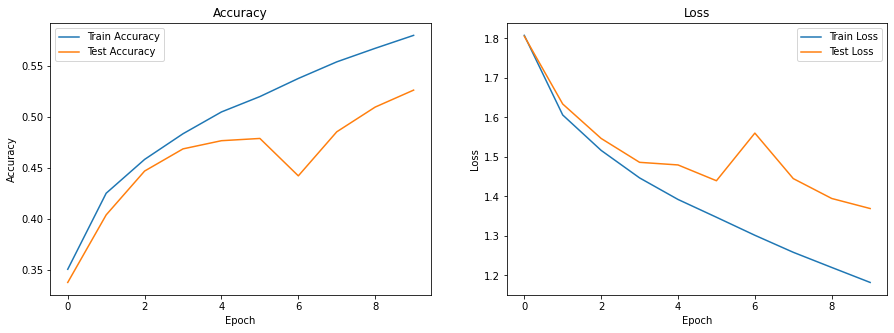

In [31]:
plot_results(history)

### 4.2 The Effect of Hyperparameters

#### 4.2.1 The Effect of Optimizer

##### 4.2.1.1 What is Momentum and Why is It Useful in Training?

Momentum is a variant of stochastic gradient descent. It can be considered as a technique to accelerate the gradient descent. It is useful in training because it can help the model to converge faster.

##### 4.2.1.2 Train the Model With Momentum = 0.5, 0.9, 0.98

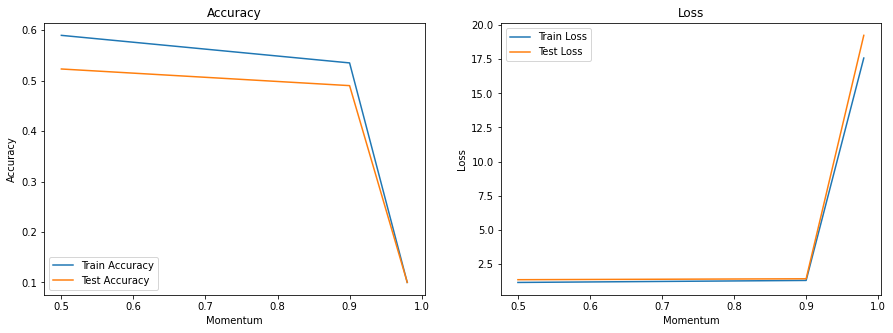

In [35]:
momentums = [0.5, 0.9, 0.98]
accuracies = []
losses = []
for momentum in momentums:
    model = keras.Sequential([
        keras.layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],)),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='tanh'),
        keras.layers.Dense(1024, activation='tanh'),
        keras.layers.Dense(1024, activation='tanh'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=momentum),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=0)
    accuracies.append((history.history['accuracy'][-1], history.history['val_accuracy'][-1]))
    losses.append((history.history['loss'][-1], history.history['val_loss'][-1]))

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(momentums, [accuracy[0] for accuracy in accuracies], label='Train Accuracy')
ax1.plot(momentums, [accuracy[1] for accuracy in accuracies], label='Test Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Momentum')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2 = plt.subplot(1, 2, 2)
ax2.plot(momentums, [loss[0] for loss in losses], label='Train Loss')
ax2.plot(momentums, [loss[1] for loss in losses], label='Test Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Momentum')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

##### 4.1.2.3 Is Increasing Momentum is Always Effective?

Too much of momentum may create issues in the model. For instance, if the momentum is too large, the model may not converge. Also, if the momentum is too small, the model will learn the data very slowly.

##### 4.1.2.4 Using Adam Optimizer

I removed all the `Tanh` layers as they were excessive and didn't have a good effect on `Adam` optimizer.

In [8]:
model = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 10)                10250     
                                                                 
Total params: 5,256,202
Trainable params: 5,256,202
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8706 - accuracy: 0.3244 - val_loss: 1.7103 - val_accuracy: 0.3764
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6996 - accuracy: 0.3883 - val_loss: 1.6402 - val_accuracy: 0.4150
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6126 - accuracy: 0.4216 - val_loss: 1.5728 - val_accuracy: 0.4334
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5528 - accuracy: 0.4390 - val_loss: 1.5378 - val_accuracy: 0.4462
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5166 - accuracy: 0.4545 - val_loss: 1.5546 - val_accuracy: 0.4467
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4782 - accuracy: 0.4708 - val_loss: 1.4911 - val_accuracy: 0.4649
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4428 - accuracy: 0.4819 - val_loss: 1.4865 - val_accuracy:

In [61]:
show_report(model, x_train, y_train)
show_report(model, x_test, y_test)

1563/1563 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      5000
           1       0.66      0.67      0.67      5000
           2       0.45      0.42      0.43      5000
           3       0.42      0.35      0.38      5000
           4       0.56      0.33      0.42      5000
           5       0.47      0.46      0.46      5000
           6       0.47      0.71      0.56      5000
           7       0.61      0.59      0.60      5000
           8       0.64      0.66      0.65      5000
           9       0.58      0.61      0.59      5000

    accuracy                           0.54     50000
   macro avg       0.54      0.54      0.53     50000
weighted avg       0.54      0.54      0.53     50000

313/313 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      1000
           1       0

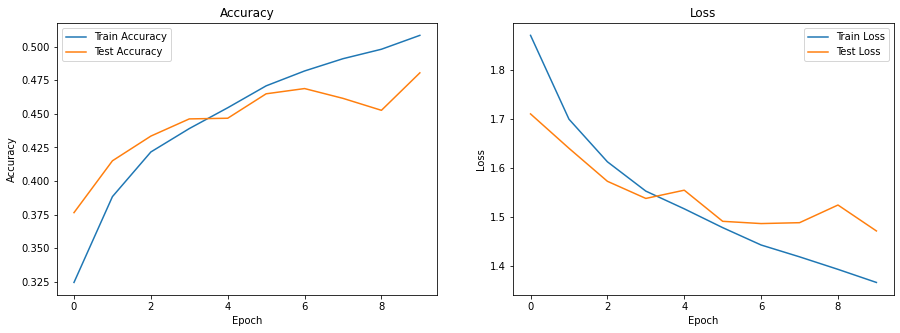

In [63]:
plot_results(history)

Adaptive optimization methods sunch as `Adam` may converge faster. However, they will perform poorly on the test set.

#### 4.2.2 The Effect of Epochs

##### 4.2.2.1 Do we always need to train the model for more than 1 epochs?  

No we don't. We should train the model until it converges.

##### 4.2.2.2 Is increasing the number of epochs always effective? How can we avoid the bad effects?

Increasing the number of epochs may not be effective. For instance, if the number of epochs is too large, the model may overfit the data.  

We can avoid the bad effects by using early stopping. Early stopping is a method that stops the training when the model starts to overfit the data.

#### 4.2.3 The Effect of Loss Function

##### 4.2.3.1 Using MSE Loss Function

In [9]:
model = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                loss='mse',
                metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_18 (Dense)            (None, 10)                10250     
                                                                 
Total params: 5,256,202
Trainable params: 5,256,202
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0882 - accuracy: 0.1899 - val_loss: 0.0863 - val_accuracy: 0.2392
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0850 - accuracy: 0.2576 - val_loss: 0.0837 - val_accuracy: 0.2798
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0828 - accuracy: 0.2904 - val_loss: 0.0819 - val_accuracy: 0.3087
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0813 - accuracy: 0.3169 - val_loss: 0.0806 - val_accuracy: 0.3312
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0801 - accuracy: 0.3365 - val_loss: 0.0794 - val_accuracy: 0.3476
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0790 - accuracy: 0.3507 - val_loss: 0.0785 - val_accuracy: 0.3575
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0781 - accuracy: 0.3621 - val_loss: 0.0777 - val_accuracy:

In [83]:
show_report(model, x_train, y_train)
show_report(model, x_test, y_test)

1563/1563 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.42      0.44      5000
           1       0.40      0.43      0.42      5000
           2       0.33      0.17      0.23      5000
           3       0.30      0.20      0.24      5000
           4       0.40      0.28      0.33      5000
           5       0.35      0.36      0.35      5000
           6       0.37      0.49      0.42      5000
           7       0.37      0.41      0.39      5000
           8       0.42      0.63      0.50      5000
           9       0.44      0.49      0.46      5000

    accuracy                           0.39     50000
   macro avg       0.38      0.39      0.38     50000
weighted avg       0.38      0.39      0.38     50000

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.47      0.43      0.45      1000
           1       0

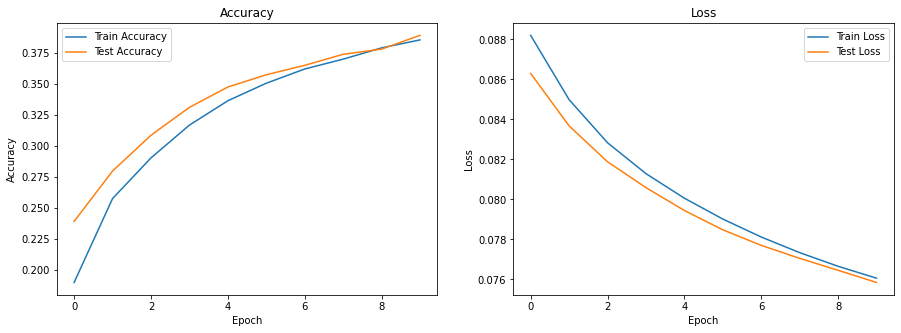

In [84]:
plot_results(history)

As it is visible above, `MSE` is not a good choice for this problem.

##### 4.2.3.2 Why is `MSE` not a good choice for classification problems? When do we use it?

The `MSE` function is non-convex for binary classification. Thus, if a binary classification model is trained with `MSE` cost function, it is not guaranteed to minimize the cost function.  

We use `MSE` for linear regression problems. 

#### 4.2.4 The Effect of Regularization

##### 4.2.4.1 Using Dropout for Each Layer with the Value of 0.1

In [10]:
model = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 1024)              3146752   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_22 (Dense)            (None, 10)               

In [14]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9479 - accuracy: 0.2847 - val_loss: 1.7847 - val_accuracy: 0.3462
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8182 - accuracy: 0.3366 - val_loss: 1.7090 - val_accuracy: 0.3882
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7736 - accuracy: 0.3550 - val_loss: 1.6978 - val_accuracy: 0.3896
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7383 - accuracy: 0.3668 - val_loss: 1.6335 - val_accuracy: 0.4079
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7070 - accuracy: 0.3841 - val_loss: 1.6598 - val_accuracy: 0.4041
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6914 - accuracy: 0.3854 - val_loss: 1.6144 - val_accuracy: 0.4209
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6747 - accuracy: 0.3936 - val_loss: 1.5960 - val_accuracy:

In [15]:
show_report(model, x_train, y_train)
show_report(model, x_test, y_test)

1563/1563 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.44      0.49      5000
           1       0.55      0.57      0.56      5000
           2       0.40      0.24      0.30      5000
           3       0.29      0.34      0.31      5000
           4       0.44      0.26      0.32      5000
           5       0.42      0.32      0.37      5000
           6       0.41      0.58      0.48      5000
           7       0.52      0.52      0.52      5000
           8       0.62      0.57      0.59      5000
           9       0.39      0.66      0.49      5000

    accuracy                           0.45     50000
   macro avg       0.46      0.45      0.44     50000
weighted avg       0.46      0.45      0.44     50000

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.43      0.48      1000
           1       0

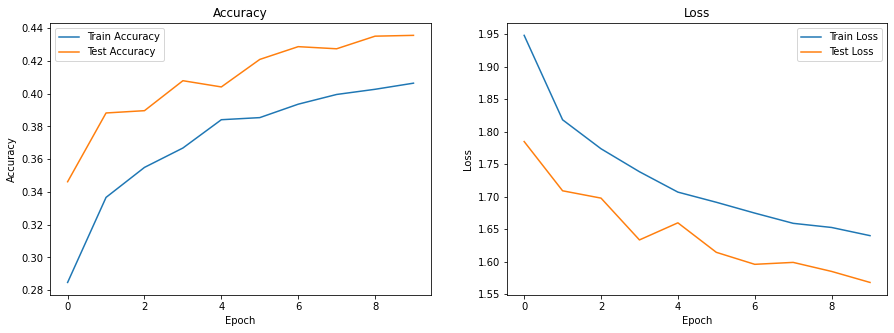

In [16]:
plot_results(history)

Regularization is used to prevent overfitting. It is done by adding a penalty term to the cost function to prevent the weights from becoming too large. The penalty term is usually a function of the L2 norm of the weights. The larger the weights are, the larger the penalty term will be. Therefore, the model will try to minimize the weights to prevent the penalty term from increasing.  

As it is visible in the above figures, the test accuracy is more than the training accuracy. This means that the model is not overfitting the data.